The **Laplacian of Gaussian (LoG)** is a foundational algorithm for **Blob Detection**. While corner detectors (like Harris or FAST) look for sharp changes in two directions, blob detectors look for regions that are either significantly brighter or darker than their surroundings.

---

### 1. The Core Concept

The LoG operation combines two steps into one mathematical function to find blobs of a specific size:

1. **Gaussian Blurring:** First, the image is smoothed with a Gaussian filter to remove noise.
2. **Laplacian Operator:** The second derivative (Laplacian) is calculated. The Laplacian is very sensitive to corners and edges, but in a smoothed image, its local maxima and minima correspond to the centers of "blobs."

### 2. How it Detects Blobs

The LoG acts as a **Circular Template Matcher**.

* When the "Mexican Hat" shape of the LoG filter perfectly matches the size of a blob in the image, the response (the output value) reaches its **maximum**.
* If the blob is much larger or much smaller than the filter, the response is weak.

### 3. Scaling for Different Blob Sizes

To find blobs of different sizes, you must vary the standard deviation () of the Gaussian:

* **Small $\sigma$:** Detects tiny, sharp blobs.
* **Large $\sigma$:** Detects large, soft blobs.

To make the response comparable across scales, we use the **Scale-Normalized Laplacian**, which multiplies the result by $\sigma^2$. This ensures that the detector doesn't "favor" small blobs over large ones.

---

### 5. Why use LoG?

* **Precision:** It is mathematically precise at finding the center of a circular feature.
* **Foundation:** The **DoG (Difference of Gaussians)**—which is used in the SIFT algorithm—is actually a fast approximation of the LoG.

### Summary Table

| Feature | Description |
| --- | --- |
| **Logic** | Finding local extrema in the second derivative of a smoothed image. |
| **Shape** | Circular/Isotropic (looks for "round" things). |
| **Strength** | Very accurate at determining the scale (size) of a blob. |
| **Weakness** | Computationally expensive because it requires multiple convolutions. |


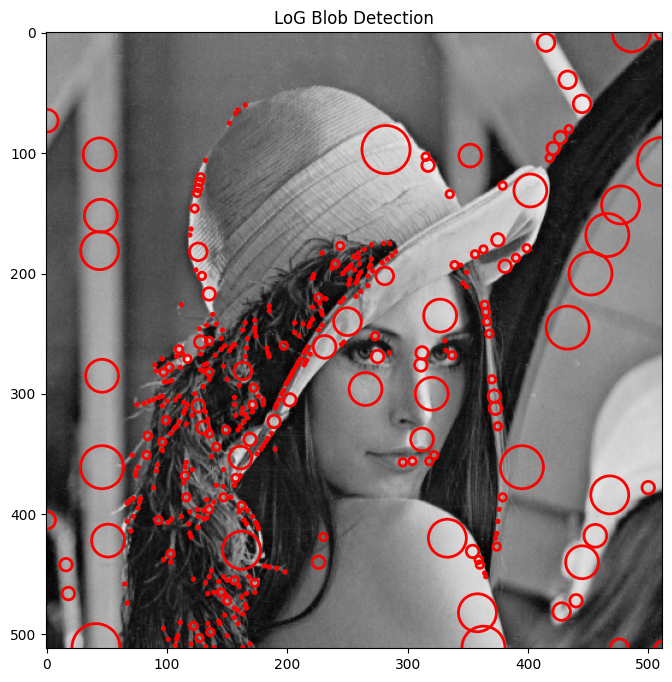

In [3]:
from skimage.feature import blob_log
import matplotlib.pyplot as plt
import cv2

# 1. Load image and convert to grayscale
image = cv2.imread('resources/lena_gray.png', 0) / 255.0

# 2. Compute LoG Blobs
# min_sigma: smallest blob size to look for
# max_sigma: largest blob size
# num_sigma: how many intermediate scales to check
# threshold: sensitivity of the detector
blobs = blob_log(image, min_sigma=1, max_sigma=20, num_sigma=10, threshold=.1)

# 3. Visualization
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')

for blob in blobs:
    y, x, r = blob
    # The radius is roughly sqrt(2) * sigma
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.title('LoG Blob Detection')
plt.show()

The **Difference of Gaussians (DoG)** is a computationally efficient shortcut for finding blobs. It is the core engine of the **SIFT** (Scale-Invariant Feature Transform) algorithm because it approximates the **Laplacian of Gaussian (LoG)** using only simple subtraction.

### 1. The Mathematical Shortcut

Instead of calculating the complex second derivative required for the Laplacian, we simply take one image, blur it at two different levels ($\sigma$ and $k\sigma$), and subtract them.$$DoG = L(x, y, k\sigma) - L(x, y, \sigma)$$

Mathematically, as the difference between the two blurring levels becomes small, the DoG result becomes nearly identical to the scale-normalized LoG.

---

### 2. How the "Octave" Stack Works

To find blobs of all possible sizes, the algorithm builds a "Pyramid" of images:

1. **Blurring:** The original image is blurred repeatedly with increasing .
2. **Subtraction:** Adjacent blurred images in the stack are subtracted to create the **DoG Space**.
3. **Downsampling:** Once the image is blurred enough, it is resized to half its dimensions, and the process repeats. This ensures we can find huge blobs without using massive filters.

---

### 3. Finding the "Extrema" (The Blob Center)

To determine if a pixel is a blob, it is compared to its **26 neighbors**:

* 8 neighbors in the **same** DoG image.
* 9 neighbors in the DoG image **above** it.
* 9 neighbors in the DoG image **below** it.

If the pixel is the maximum or minimum of all 26 neighbors, it is marked as a potential blob center (keypoint).

---

### Summary Table: LoG vs. DoG

| Feature | Laplacian of Gaussian (LoG) | Difference of Gaussians (DoG) |
| --- | --- | --- |
| **Complexity** | High (2nd Derivative) | Low (Subtraction) |
| **Accuracy** | Mathematically precise | Close Approximation |
| **Use Case** | Scientific/Medical Imaging | **SIFT** / General Computer Vision |
| **Efficiency** |  with one scale |  with multiple scales via subtraction |

**Now that we've found the blobs using DoG, would you like to see the next step of SIFT: assigning an Orientation to these blobs so they become rotation-invariant?**

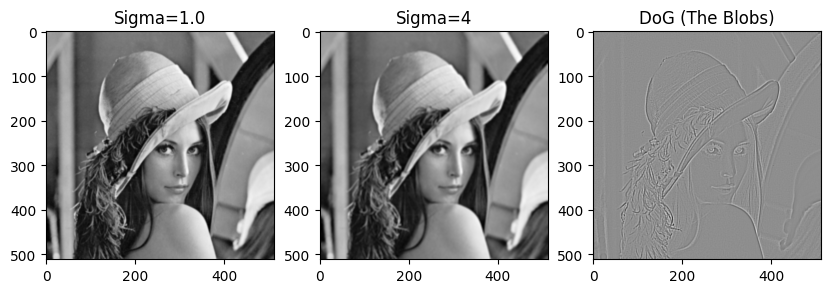

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load image
image = cv2.imread('resources/lena_gray.png', 0) / 255.0

# 2. Apply two different Gaussian blurs
blur_small = cv2.GaussianBlur(image, (5, 5), sigmaX=1.0)
blur_large = cv2.GaussianBlur(image, (5, 5), sigmaX=4)
# 3. Subtract to get the Difference of Gaussians
dog = blur_large - blur_small

# 4. Visualize the "Mexican Hat" response
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1); plt.imshow(blur_small, cmap='gray'); plt.title('Sigma=1.0')
plt.subplot(1, 3, 2); plt.imshow(blur_large, cmap='gray'); plt.title('Sigma=4')
plt.subplot(1, 3, 3); plt.imshow(dog, cmap='gray'); plt.title('DoG (The Blobs)')
plt.show()